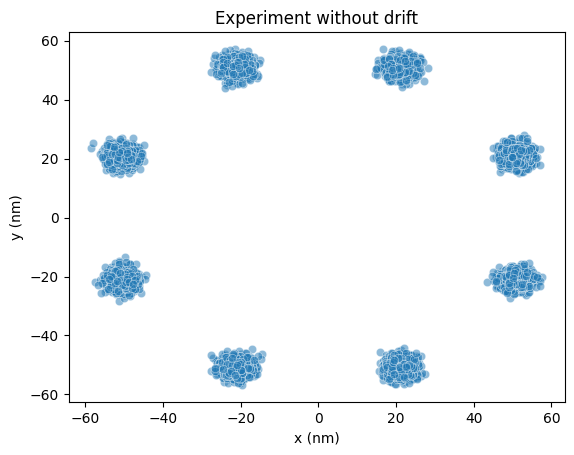

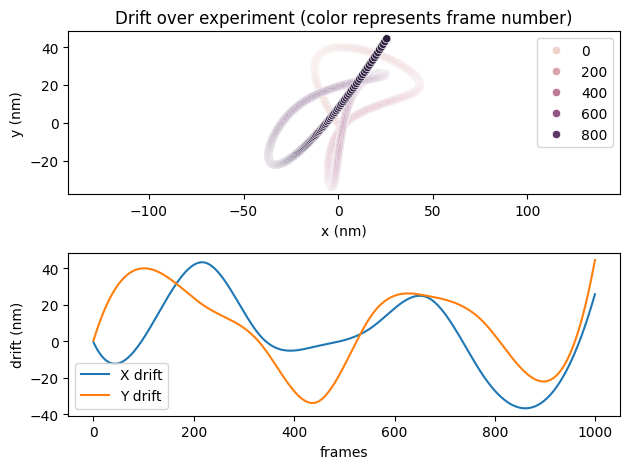

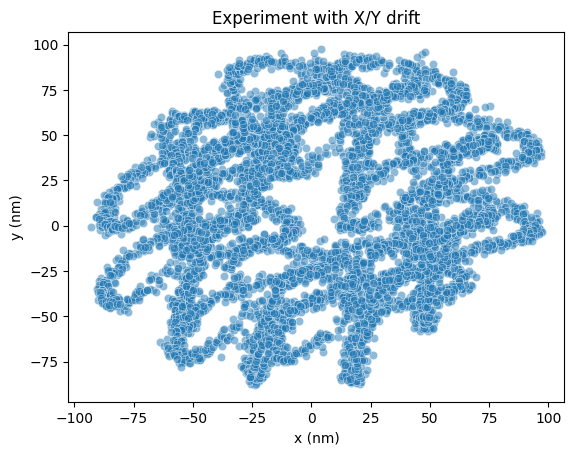

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline
import seaborn as sns

np.random.seed(42)

def octagon_nodes(side_length=1):
    # Calculate the coordinates of octagon nodes
    angle = np.pi / 8
    x = side_length * np.cos(angle + np.arange(8) * np.pi / 4)
    y = side_length * np.sin(angle + np.arange(8) * np.pi / 4)
    return np.column_stack((x, y))

emitters = octagon_nodes(55)

def generate_random_drift(n_frames=100):
    subsample = 10
    # Generate random control points
    frame = np.linspace(0, n_frames, subsample)
    drift = np.random.uniform(-50, 50, size=subsample)
    drift[0] = 0

    # Create a cubic spline
    cs = UnivariateSpline(frame, drift, s=300)

    # Generate points along the spline
    x_fine = np.linspace(0, n_frames, n_frames)
    drift_fine = cs(x_fine)

    return drift_fine



def run_experiment(emitters, n_frames, noise, blinking_prob=0.5, drift=False):
    if drift:
        x_drift = generate_random_drift(n_frames)
        y_drift = generate_random_drift(n_frames)
        
        # Plot the result
        fig, axs = plt.subplots(2, 1)
        # plt.tight_layout()
        axs[1].plot(x_drift, label='X drift')
        axs[1].plot(y_drift, label='Y drift')
        axs[1].legend()
        axs[1].set_xlabel('frames')
        axs[1].set_ylabel('drift (nm)')
        
        import seaborn as sns
        sns.scatterplot(x=x_drift, y=y_drift, hue=np.arange(x_drift.shape[0]), ax=axs[0])
        axs[0].axis('equal')
        axs[0].set_ylabel('y (nm)')
        axs[0].set_xlabel('x (nm)')
        
        axs[0].set_title('Drift over experiment (color represents frame number)')
        plt.tight_layout()
        plt.savefig('./sim_drift.png')
        plt.show()

    else:
        x_drift = np.zeros((n_frames,))
        y_drift = np.zeros((n_frames,))

    locs = []
    for i in range(n_frames):
        emitters_idx = np.argwhere(np.random.uniform(size=emitters.shape) > (1-blinking_prob))[:, 0]
        if len(emitters_idx) == 0:
            continue
        frame_emitters = emitters[emitters_idx]
        frame_noise = np.random.normal(0, noise, size=frame_emitters.shape)
        frame_emitters[:, 0] += x_drift[i]
        frame_emitters[:, 1] += y_drift[i]
        frame = np.array([i] * len(emitters_idx))[:, None].astype(int)
        frame_locs = frame_emitters + frame_noise
        locs.append(np.hstack((frame, frame_locs)))
    locs = np.concatenate(locs)
    locs = pd.DataFrame(locs, columns=['frame', 'x (nm)', 'y (nm)'])
    locs['frame'] = locs['frame'].astype(int)
    return locs

locs = run_experiment(emitters, 1000, 2)
sns.scatterplot(data=locs, x='x (nm)', y='y (nm)', alpha=0.5)
plt.title('Experiment without drift')
plt.savefig('./no_drift.png')
plt.show()


locs = run_experiment(emitters, 1000, 2, drift=True)
sns.scatterplot(data=locs, x='x (nm)', y='y (nm)', alpha=0.5)
plt.title('Experiment with X/Y drift')
plt.savefig('./with_drift.png')
plt.show()
    

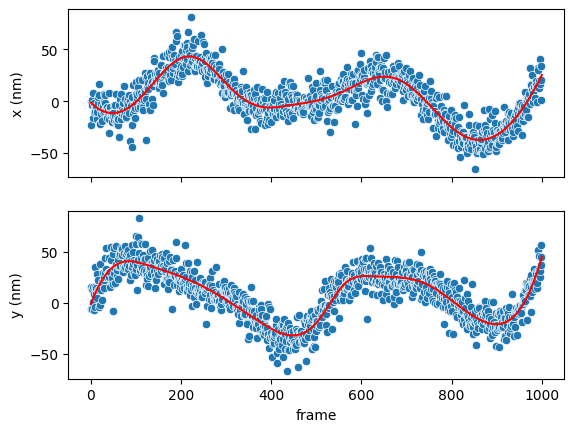

In [2]:
from scipy.interpolate import splrep, BSpline

def fit_1d_gaussian(x, y, s):
    spline = BSpline(*splrep(x, y, s=len(y)*s))

    _x = np.linspace(x.min(), x.max()+1, 1000)
    _y = spline(_x)
    return _x, _y

locs_mean = locs.groupby('frame').mean().reset_index()

drifts = []
fig, axs = plt.subplots(2, 1, sharex=True)
for c, s, ax in (('x (nm)', 110, axs[0]), ('y (nm)', 120, axs[1])):
    sns.scatterplot(data=locs_mean, x='frame', y=c, ax=ax)
    x, y = fit_1d_gaussian(locs_mean['frame'].to_numpy(), locs_mean[c].to_numpy(), s)
    drifts.append(y)
    sns.lineplot(x=x, y=y, c='red', ax=ax)
plt.savefig(f'drift_model.png')
plt.show()

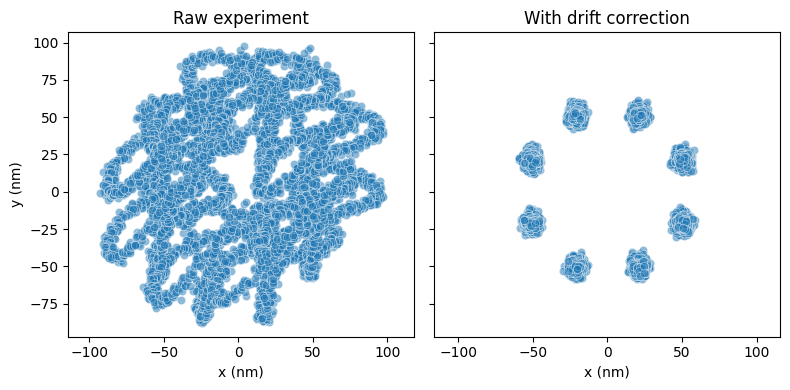

In [3]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=locs, x='x (nm)', y='y (nm)', alpha=0.5, ax=axs[0])
axs[0].axis('equal')
axs[0].set_ylim((-125, 125))

locs_fixed = locs.copy(deep=True)

def apply_drift(entry, drift, col):
    return entry[col] - drift[entry['frame']]


locs_fixed['x (nm)'] = [apply_drift(e, drifts[0], 'x (nm)') for e in locs_fixed.to_dict(orient="records")]
locs_fixed['y (nm)'] = [apply_drift(e, drifts[1], 'y (nm)') for e in locs_fixed.to_dict(orient="records")]

sns.scatterplot(data=locs_fixed, x='x (nm)', y='y (nm)', alpha=0.5, ax=axs[1])

axs[1].axis('equal')
axs[0].set_title('Raw experiment')
axs[1].set_title('With drift correction')
plt.tight_layout()
plt.savefig('./drift_reconstruction_result.png')
plt.show()